In [1]:
!pip install -q timm tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.7 MB/s eta 0:00:00


In [2]:
# Install timm + tqdm if needed
!pip install -q timm tqdm

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import timm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm.auto import tqdm




In [3]:
# cuDNN autotune for fixed input sizes
torch.backends.cudnn.benchmark = True

# Device detection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Conditional AMP setup
if device.type == 'cuda':
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler()
else:
    from contextlib import nullcontext
    autocast = nullcontext  # no-op contextmanager on CPU
    scaler = None

Using device: cuda


/tmp/ipykernel_19/4173437918.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [4]:
class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        classes = sorted(
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        )
        self.class_to_idx = {cls: i for i, cls in enumerate(classes)}
        for cls in classes:
            folder = os.path.join(root_dir, cls)
            for fname in os.listdir(folder):
                path = os.path.join(folder, fname)
                if os.path.isfile(path) and fname.lower().endswith(('.jpg','jpeg','.png')):
                    self.samples.append((path, self.class_to_idx[cls]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


In [5]:
# Adjust to your mounted path
dataset_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train'

# Sanity check
print("Classes:", os.listdir(dataset_dir))

# Transforms (ViT ⇒ 224×224)
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])
val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])

# Build dataset & split
full_ds = FaceDataset(dataset_dir, transform=train_tfms)
val_size = int(0.2 * len(full_ds))
train_ds, val_ds = random_split(
    full_ds, [len(full_ds)-val_size, val_size],
    generator=torch.Generator().manual_seed(42)
)
# switch to val transforms
val_ds.dataset.transform = val_tfms

# DataLoaders (4 workers—adjust if you hit freezes)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                          num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False,
                          num_workers=4, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Classes: ['Fake', 'Real']
Train batches: 3501, Val batches: 875


In [6]:
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2
)


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [7]:
num_epochs = 30
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, num_epochs+1):
    # — Train —
    model.train()
    run_loss, run_correct, run_total = 0.0, 0, 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]", leave=False)
    for imgs, labels in train_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        # mixed-precision if CUDA
        with autocast():
            logits = model(imgs)
            loss = criterion(logits, labels)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        run_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        run_correct += (preds == labels).sum().item()
        run_total += imgs.size(0)
        train_bar.set_postfix(loss=run_loss/run_total, acc=run_correct/run_total)

    train_loss = run_loss / run_total
    train_acc  = run_correct / run_total

    # — Validate —
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_probs, all_labels = [], []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Val]  ", leave=False)
    with torch.no_grad():
        for imgs, labels in val_bar:
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast():
                logits = model(imgs)
                loss = criterion(logits, labels)

            val_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += imgs.size(0)

            probs = torch.softmax(logits, dim=1)[:,1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_bar.set_postfix(loss=val_loss/val_total, acc=val_correct/val_total)

    val_loss  /= val_total
    val_acc   = val_correct / val_total

    scheduler.step(val_loss)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} → "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"Val:   loss={val_loss:.4f}, acc={val_acc:.4f}")


Epoch 1/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

/tmp/ipykernel_19/3043210800.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

/tmp/ipykernel_19/3043210800.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/30 → Train: loss=0.1949, acc=0.9163 | Val:   loss=0.1245, acc=0.9494


Epoch 2/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 2/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 2/30 → Train: loss=0.1250, acc=0.9488 | Val:   loss=0.1350, acc=0.9468


Epoch 3/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 3/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>

Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>        
Traceback (most recent call last):

self._shutdown_workers()self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
  File "/usr/local/lib/pyt

Epoch 3/30 → Train: loss=0.1079, acc=0.9565 | Val:   loss=0.1218, acc=0.9490


Epoch 4/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 4/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 4/30 → Train: loss=0.0967, acc=0.9607 | Val:   loss=0.1523, acc=0.9357


Epoch 5/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 5/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 5/30 → Train: loss=0.0851, acc=0.9658 | Val:   loss=0.1006, acc=0.9599


Epoch 6/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 6/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 6/30 → Train: loss=0.0790, acc=0.9676 | Val:   loss=0.1159, acc=0.9546


Epoch 7/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 7/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 7/30 → Train: loss=0.0718, acc=0.9711 | Val:   loss=0.1450, acc=0.9477


Epoch 8/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    self._shutdown_workers()^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^^    ^^if w.is_alive():^^^
^^ ^ ^ ^^

Epoch 8/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
          File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()self._shutdown_workers()Exception ignored in:     se

Epoch 8/30 → Train: loss=0.0665, acc=0.9730 | Val:   loss=0.1486, acc=0.9468


Epoch 9/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 9/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 9/30 → Train: loss=0.0261, acc=0.9893 | Val:   loss=0.0793, acc=0.9748


Epoch 10/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 10/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 10/30 → Train: loss=0.0148, acc=0.9938 | Val:   loss=0.1015, acc=0.9742


Epoch 11/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 11/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 11/30 → Train: loss=0.0105, acc=0.9957 | Val:   loss=0.1267, acc=0.9730


Epoch 12/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 12/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 12/30 → Train: loss=0.0081, acc=0.9967 | Val:   loss=0.1278, acc=0.9738


Epoch 13/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 13/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in:     if w.is_alive():
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>  
Exception ignored in: Traceback (most recent call last):
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
 
Exception ignored in:     Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0> self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

 
    ^  File "/usr/local/lib

Epoch 13/30 → Train: loss=0.0045, acc=0.9983 | Val:   loss=0.1385, acc=0.9739


Epoch 14/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__



    Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>  File "/usr/local/lib/python3.11/d

Epoch 14/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 14/30 → Train: loss=0.0033, acc=0.9987 | Val:   loss=0.1529, acc=0.9739


Epoch 15/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 15/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 15/30 → Train: loss=0.0027, acc=0.9989 | Val:   loss=0.1634, acc=0.9738


Epoch 16/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 16/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 16/30 → Train: loss=0.0020, acc=0.9992 | Val:   loss=0.1650, acc=0.9738


Epoch 17/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 17/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 17/30 → Train: loss=0.0019, acc=0.9993 | Val:   loss=0.1672, acc=0.9740


Epoch 18/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 18/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():A

Epoch 18/30 → Train: loss=0.0018, acc=0.9993 | Val:   loss=0.1695, acc=0.9739


Epoch 19/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0> 
Traceback (most recent call last):
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers()
 ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in:     ^<function _MultiProcessin

Epoch 19/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 19/30 → Train: loss=0.0017, acc=0.9994 | Val:   loss=0.1697, acc=0.9739


Epoch 20/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 20/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 20/30 → Train: loss=0.0017, acc=0.9994 | Val:   loss=0.1700, acc=0.9739


Epoch 21/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 21/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 21/30 → Train: loss=0.0017, acc=0.9994 | Val:   loss=0.1702, acc=0.9739


Epoch 22/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 22/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 22/30 → Train: loss=0.0017, acc=0.9994 | Val:   loss=0.1702, acc=0.9739


Epoch 23/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 23/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
if w.is_alive(): 
            ^ ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^assert self._parent_pid == os.getpid(), 'can only test a child process'
      File "/usr/lib/python3

Epoch 23/30 → Train: loss=0.0017, acc=0.9994 | Val:   loss=0.1702, acc=0.9739


Epoch 24/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>
IOStream.flush timed out
IOStream.flush timed out

Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

         

Epoch 24/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 24/30 → Train: loss=0.0017, acc=0.9994 | Val:   loss=0.1702, acc=0.9740


Epoch 25/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 25/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 25/30 → Train: loss=0.0017, acc=0.9994 | Val:   loss=0.1702, acc=0.9739


Epoch 26/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 26/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 26/30 → Train: loss=0.0017, acc=0.9994 | Val:   loss=0.1703, acc=0.9739


Epoch 27/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 27/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 27/30 → Train: loss=0.0017, acc=0.9994 | Val:   loss=0.1702, acc=0.9739


Epoch 28/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 28/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>
Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>IOStream.flush timed out
IOStream.flush timed out
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f990ef3a7a0>

Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()          

Epoch 28/30 → Train: loss=0.0017, acc=0.9994 | Val:   loss=0.1703, acc=0.9739


Epoch 29/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 29/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 29/30 → Train: loss=0.0017, acc=0.9994 | Val:   loss=0.1703, acc=0.9739


Epoch 30/30 [Train]:   0%|          | 0/3501 [00:00<?, ?it/s]

Epoch 30/30 [Val]  :   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 30/30 → Train: loss=0.0017, acc=0.9994 | Val:   loss=0.1703, acc=0.9739


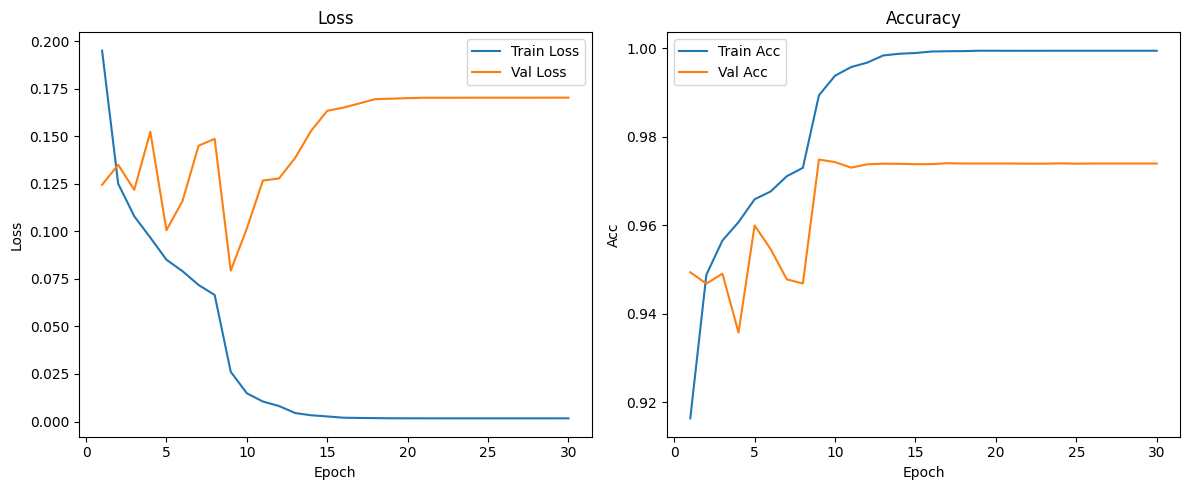

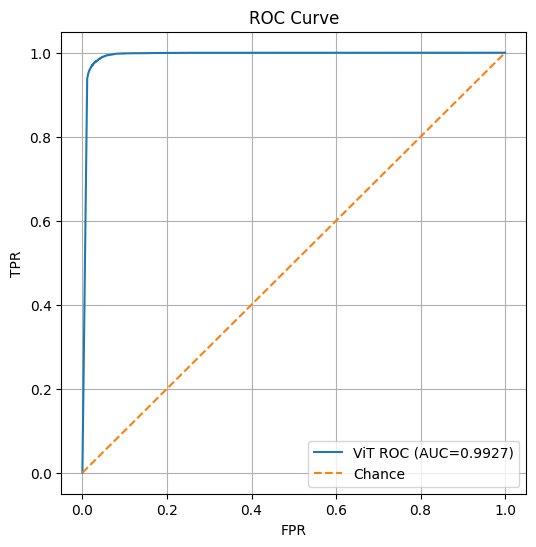

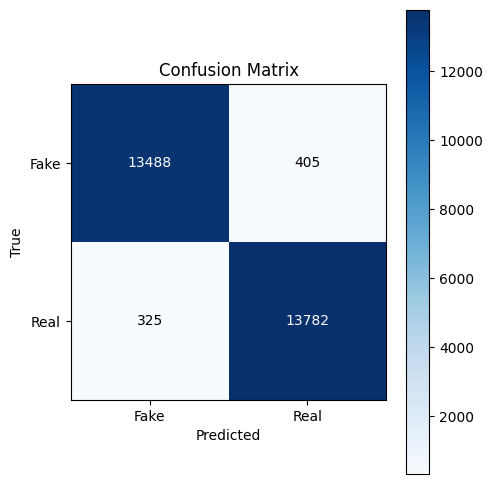

Classification Report:

              precision    recall  f1-score   support

        Fake       0.98      0.97      0.97     13893
        Real       0.97      0.98      0.97     14107

    accuracy                           0.97     28000
   macro avg       0.97      0.97      0.97     28000
weighted avg       0.97      0.97      0.97     28000



In [8]:
# 1) Loss & Accuracy curves
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'],   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.title('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()

# 2) ROC Curve & AUC
y_true = np.array(all_labels)
y_prob = np.array(all_probs)
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ViT ROC (AUC={roc_auc:.4f})')
plt.plot([0,1],[0,1],'--', label='Chance')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.grid(True)
plt.show()

# 3) Confusion Matrix & Classification Report
y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)
classes = ['Fake','Real']

plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0,1], classes); plt.yticks([0,1], classes)
th = cm.max() / 2
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center',
                 color='white' if cm[i,j] > th else 'black')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.tight_layout(); plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))
